# Colocalization between placental mQTL, psychiatric and developmental traits

Idea: for all heritable CpGs, test for colocalization between traits and GWAS summary statistics for conditions where a significant proportion of heritability can be explained by placental mQTL.
Traits to include:
* Neuropsychiatric
    1. OCD
    1. TS
    1. ADHD
    1. ASD
    1. MDD
    1. BIP
    1. AN
    1. SCZ
* Developmental: 
    1. Pubertal Growth Start
    1. Asthma
    1. Child BMI
    1. Child Onset Asthma

In [2]:
library(tidyverse)
library(data.table)
library(coloc)
library(bigsnpr)
library(here)
library(parallel)
library(glue)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is a new update to coloc.

Loading required package: bigstatsr

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
if (file.exists(here("data","marginal_mcpg_bonf.txt.gz"))){
    marginal_bonf <- fread(here("data","marginal_mcpg_bonf.txt.gz"),key="SNP")
}else{
    marginal <- fread(here("data","delahaye_richs_marginal_mecs_maf01.txt.gz"))
    marginal_bonf <- fread(here("data","delahaye_richs_marginal_bonf_maf05.txt.gz"))[Chr != 23]
    marginal_bonf <- marginal[Probe %in%marginal_bonf$Probe]
    fwrite(marginal_bonf,here("data","marginal_mcpg_bonf.txt.gz"),row.names=F,quote=F,sep='\t')
}

In [3]:
rds < -snp_readBed2(
    "/arc/project/st-dennisjk-1/shared/data/1000G_EUR_ldsc_data/1000G_EUR_Phase3_plink/1000G.EUR.QC.ALL.bed",
    backingfile=tempfile(),
)

In [ ]:
reference < -snp_attach(rds)

In [5]:
str(reference)

List of 3
 $ genotypes:Reference class 'FBM.code256' [package "bigstatsr"] with 16 fields
  ..$ extptr      :<externalptr> 
  ..$ extptr_rw   :<externalptr> 
  ..$ nrow        : int 489
  ..$ ncol        : int 9997231
  ..$ type        : Named int 1
  .. ..- attr(*, "names")= chr "unsigned char"
  ..$ backingfile : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.bk"
  ..$ is_read_only: logi FALSE
  ..$ address     :<externalptr> 
  ..$ address_rw  :<externalptr> 
  ..$ bk          : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.bk"
  ..$ rds         : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.rds"
  ..$ is_saved    : logi TRUE
  ..$ type_chr    : chr "unsigned char"
  ..$ type_size   : int 1
  ..$ file_size   : num 4.89e+09
  ..$ code256     : num [1:256] 0 1 2 NA NA NA NA NA NA NA ...
  ..and 26 methods, of which 12 are  possibly relevant:
  ..  add_columns, as.FBM, bm, bm.desc, check_dimensions,
  ..  check_write_permis

In [ ]:
compute_coloc <- function(SNP,mqtl,gwas,method="coloc", type="quant",s=NULL){# SNP must be in SNP column of mqtl and gwas
    D1 <- list(
            beta = mqtl$b,
            varbeta = mqtl$SE^2,
            snp = mqtl$SNP,
            position = mqtl$BP,
            N = 400,
            MAF = mqtl$Freq,
            type="quant"
        )
    D2 <- list(
            pvalues = pnorm(-abs(gwas$Z))*2,
            z=gwas$Z,
            snp = gwas$SNP,
            MAF = snp_MAF(reference$genotypes,ind.col = match(gwas$SNP,reference$map$marker.ID)),
            N = min(gwas$N),
            type=type,
            s = s
        )
    if(method == "susie"){
        LD <- snp_cor(reference$genotypes,ind.col = match(SNP, reference$map$marker.ID))^2
        LD <- as.matrix(LD)
        colnames(LD) <- SNP
        rownames(LD) <- SNP
        D1$LD <- LD
        D2$LD <- LD
        S1 <- runsusie(D1)
        S2 <- runsusie(D2)
        return(coloc.susie(S1,S2))
    }else if(method == "coloc"){
        return(coloc.abf(D1,D2))
    }else{
        return(NULL)
    }
}

In [14]:
gwas <- fread("../../tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",key="SNP")

tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]

eligible_cpg <- unlist(mclapply(
    unique(tmp_marginal_bonf$Probe),
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
        return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
    },
    mc.cores=16
))
test <- mclapply(
    unique(marginal_bonf$Probe)[eligible_cpg],
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[SNP %in% mqtl$SNP]
        res <- suppressMessages(compute_coloc(mqtl$SNP,mqtl,gwas_tmp,method="coloc",s=0.36,type="cc")$summary)
        return(res)
    },
    mc.cores=16
)

names(test) <- unique(marginal_bonf$Probe)[eligible_cpg]
result_adhd <- rbindlist(lapply(test,function(x)data.table(t(x))))
result_adhd

# Repeating above for all psychiatric GWAS

In [3]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.fs.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.cc.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgcAN2.2019-07_refmt.vcf.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/AUDIT_UKB_2018_AJP_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/Cannabis_ICC_23andmetop_UKB_het_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/iPSYCH-PGC_ASD_Nov2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/ocd_aug2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_alcdep.eur_unrelated.aug2018_release_refmt.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_bip_2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC_UKB_depression_genome-wide_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/MDD2018_ex23andMe.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC3_SCZ_wave3_public.v2.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/tag.cpd.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/TS_Oct2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pts_all_freeze2_overall.results.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    0.36,
    NULL,
    0.33,
    0.23,
    NULL,
    0.30,
    0.40,
    0.28,
    0.26,
    0.15,
    0.34,
    0.35,
    0.42,
    NULL,
    0.34,
    0.15,
)

ERROR: Error in eval(expr, envir, enclos): object 'sumstat_files' not found


In [ ]:
result <- list()
for( i in 1:length(sumstat_files)){
    gwas <- fread(sumstat_files[i])
    tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]
    eligible_cpg <- unlist(mclapply(
        unique(tmp_marginal_bonf$Probe),
        function(probe){
            mqtl <- tmp_marginal_bonf[Probe == probe]
            gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
            return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
        },
        mc.cores=16
    ))
    if(sum(eligible_cpg) ){
        test <- mclapply(
            unique(tmp_marginal_bonf$Probe)[eligible_cpg],
            function(probe){
                mqtl <- tmp_marginal_bonf[Probe == probe]
                gwas_tmp <- gwas[SNP %in% mqtl$SNP]
                res <- suppressMessages(
                    compute_coloc(
                        mqtl$SNP,
                        mqtl,
                        gwas_tmp,
                        method="coloc",
                        s=sample_prev[i],
                        type=ifelse(is.null(sample_prev[i]),"quant","cc")
                    )$summary
                )
                return(res)
            },
            mc.cores=16
        )
        names(test) <- unique(tmp_marginal_bonf$Probe)[eligible_cpg]
        res <- rbindlist(lapply(test,function(x)data.table(t(x))))
        result[[trait_names[i]]] <- res
    }
}

In [64]:
str(result)

 list()


# Neonatal Traits

In [ ]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PGF_PGM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_Obesity_Meta_Analysis_1.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG-TotalGWG-Offspring.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PTF_PTM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_BMI_HapMap_DISCOVERY.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_10F_12M_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_HC_DISCOVERY.v2.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 0.0296
)

## Summary of all trait colocalization

In [4]:
trait_coloc <- dir(here("data"),pattern= ".*colocalization.txt",full.names = TRUE)
all_coloc <- lapply(trait_coloc,fread)
names(all_coloc) <- gsub(".*/(.*)_colocalization.txt","\\1",trait_coloc)
coloc_table <- rbindlist(all_coloc,idcol="GWAS")

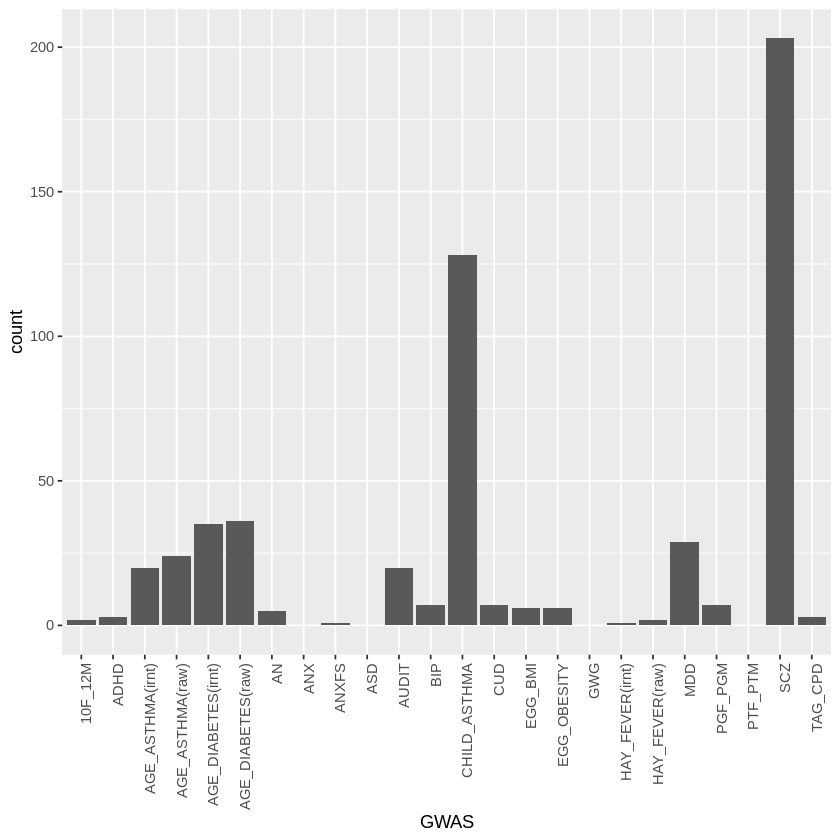

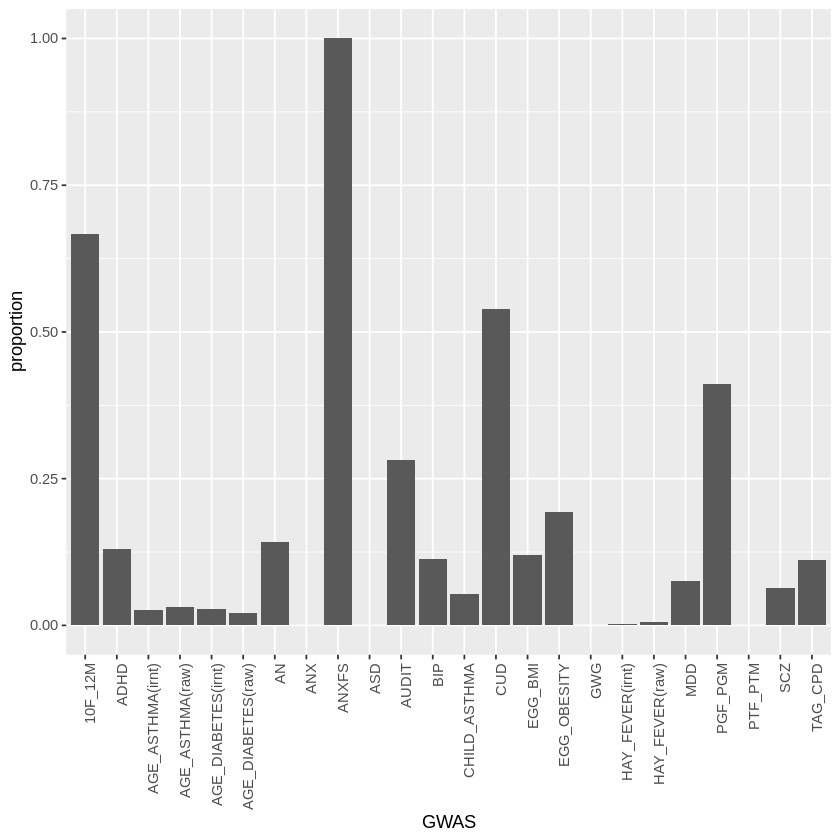

In [5]:
ggplot(
    coloc_table[,.(proportion = sum(PP.H4.abf > 0.9) / .N,count=sum(PP.H4.abf >0.9)),by=GWAS],
    aes(GWAS,count)
) +
geom_col() +
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))
ggplot(
    coloc_table[,.(proportion = sum(PP.H4.abf > 0.9) / .N,count=sum(PP.H4.abf >0.9)),by=GWAS],
    aes(GWAS,proportion)
) +
geom_col() + 
theme(axis.text.x = element_text(angle=90, hjust=1, vjust=1))

### Quick follow up experiments
1. Plot number of colocalized CpGs as function of trait heritability
2. Plot number of colocalized CpGs as a function of proportion of heritability explained by placental mQTL
3. Plot number of genes corresponding to colocalized CpGs

In [41]:
# load in heritability results
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results_independent <- function(path){
    part_heritability <- rbindlist(lapply(
          dir(
            path,
            pattern = "[marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female]_bin_CPP_her_.*.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(bin_CPP_her)_(.*).results$")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)[1, !"Category"]
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  mQTL_group = labels[1],
                  annotation = labels[2],
                  GWAS = labels[3])]
              return(dt)
            }
          }
        ))
    log_files <- dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE
    )
    log_files <-log_files[!grepl("_shared",log_files)]
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE,
        
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*).log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[3] & annotation == labels[2]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[2],
            GWAS = labels[3]
          )
          return(dt)
        }
      }
    ))
    heritability <- heritability[which(!duplicated(GWAS))]
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}

part_heritability_results <- function(path,modifier){
    part_heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.results$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*){modifier}.results"))[-c(1)]
        if (any(is.na(labels))) {zzzzzzz
          return(data.table())
        } else {
          dt <- fread(f)
          dt[, 
            `:=`(
              Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
              annotation = labels[1],
              GWAS = labels[2])]
          return(dt)
        }
      }
    ))
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.log$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(bin_CPP_her)_(.*){modifier}.log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[2] & annotation == labels[1]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[1],
            GWAS = labels[2]
          )
          return(dt)
        }
      }
    ))
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}
annotation_SD <- function(path,file_pattern){
    annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
    return(apply(annots[,-c(1,2,3,4)],2,sd))    
}
pgc_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/")
neonatal_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/")

                                 
pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "meta_STDERR_rmdd_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "RMDD Males",
    "meta_STDERR_rmdd_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "RMDD Females",
    "ocd_aug2017" = "OCD",
    "OCD_meta_male_auto_072416.gz" = "OCD Males",
    "OCD_meta_female_auto_072416.gz" = "OCD Females",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "ukbb_anxiety.gwas.imputed_v3.both_sexes.tsv.gz.fixed" = "UKBB-ANX",
    "ukbb_anxiety.gwas.imputed_v3.male.tsv.gz.fixed" = "UKBB-ANX Males",
    "ukbb_anxiety.gwas.imputed_v3.female.tsv.gz.fixed" = "UKBB-ANX Females",
    "anxiety.meta.full.fs.tbl" = "ANXFS",
    "pgc_bip_2018" = "BIP",
    "meta_STDERR_bip_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "BIP Males",
    "meta_STDERR_bip_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "BIP Females",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "meta_STDERR_scz_eur_auto_M1_08_gcOFF_pgc.txt.gz" = "SCZ Males",
    "meta_STDERR_scz_eur_auto_F1_08_gcOFF_pgc.txt.gz" = "SCZ Females",
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "TS_Oct2018" = "TS",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)
neonatal_GWAS_key <- c(
    "age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv" = "AGE_ASTHMA(norm)",
    "age_asthma_irnt.gwas.imputed_v3.female.tsv" = "ASTHMA Age(norm) Females",
    "age_asthma_irnt.gwas.imputed_v3.male.tsv"= "ASTHMA Age(norm) Males",
    "age_asthma_raw.gwas.imputed_v3.both_sexes.tsv" = "AGE_ASTHMA(raw)",
    "age_asthma_raw.gwas.imputed_v3.female.tsv" = "ASTHMA Age(raw) Females",
    "age_asthma_raw.gwas.imputed_v3.male.tsv" = "ASTHMA Age(raw) Males",
    "age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv" = "AGE_DIABETES(norm)",
    "age_diabetes_irnt.gwas.imputed_v3.female.tsv"= "DIABETES Age(norm) Females",
    "age_diabetes_irnt.gwas.imputed_v3.male.tsv"= "DIABETES Age(norm) Males",
    "age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv"= "AGE_DIABETES(raw)",
    "age_diabetes_raw.gwas.imputed_v3.female.tsv"= "DIABETES Age(raw) Females",
    "age_diabetes_raw.gwas.imputed_v3.male.tsv"= "DIABETES Age(raw) Males",
    "age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER(norm)",
    "age_hay_fever_irnt.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(norm) Females",
    "age_hay_fever_irnt.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(norm) Males",
    "age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER(raw)",
    "age_hay_fever_raw.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(raw) Females",
    "age_hay_fever_raw.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(raw) Males",
    "CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC" = "CHILD_ASTHMA",
    "EGG_BMI_HapMap_DISCOVERY.txt" = "EGG_BMI",
    "EGG_HC_DISCOVERY.v2.txt" = "Head Circumference",
    "EGG_Obesity_Meta_Analysis_1.txt" = "EGG_OBESITY",
    "EGG_TANNER_females.v2.txt" = "TANNER Stage Females",
    "EGG_TANNER_males_and_females_combined.v2.txt" = "TANNER Stage",
    "EGG_TANNER_males.v2.txt" = "TANNER Stage Males",
    "EGG-TotalGWG-Offspring.txt" = "GWG",
    "Pubertal_growth_10F_12M_combined.txt" = "10F_12M",
    "Pubertal_growth_10F.txt" = "Pubertal Growth Start Females",
    "Pubertal_growth_12M.txt" = "Pubertal Growth Start Males",
    "Pubertal_growth_PGF_PGM_combined.txt" = "PGF_PGM}",
    "Pubertal_growth_PGF.txt" = "Total Pubertal Growth Females",
    "Pubertal_growth_PGM.txt" = "Total Pubertal Growth Males",
    "Pubertal_growth_PTF_PTM_combined.txt" = "PTF_PTM",
    "Pubertal_growth_PTF.txt" = "Late Pubertal Growth Females",
    "Pubertal_growth_PTM.txt" = "Late Pubertal Growth Males",
    "ukbb_preeclampsia.gwas.imputed_v3.female.tsv"= "Pre-Eclampsia During Pregnancy"
)
                                                                 
                                 
neonatal_part_heritability_independent_df <- neonatal_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key)) %>% na.omit()
                                 
pgc_part_heritability_independent_df <- pgc_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))  %>% na.omit()
                                 

In [ ]:
manifest < -fread("../../450k_annotation.csv")  # Gene mapping

In [45]:
all_data <- merge(merge(rbind(pgc_part_heritability_independent_df,neonatal_part_heritability_independent_df)[Category == "Cross-sex"],coloc_table,by="GWAS"),manifest,by.x="probe",by.y="Name")
head(all_data)

probe,GWAS,annotation,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,⋯,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>
cg00022997,AGE_DIABETES(raw),bin_CPP_her,0.3156141,0.4298381,0.19921453,1.361910,0.63119648,0.5596483227,-2.623159e-09,⋯,,,,,,NA,6:31758628-31759271,,,TRUE
cg00022997,CHILD_ASTHMA,bin_CPP_her,0.3156141,0.4368361,0.04384894,1.384083,0.13893213,0.0078783023,-1.163252e-09,⋯,,,,,,NA,6:31758628-31759271,,,TRUE
cg00022997,SCZ,bin_CPP_her,0.3156141,0.3393967,0.02157744,1.075353,0.06836653,0.2722642734,-1.287894e-09,⋯,,,,,,NA,6:31758628-31759271,,,TRUE
cg00026776,AGE_ASTHMA(raw),bin_CPP_her,0.3156141,0.5774916,0.07733339,1.829739,0.24502511,0.0005296879,1.432030e-08,⋯,C6orf10,NM_006781,Body,,,NA,,,,NA
cg00026776,AGE_DIABETES(raw),bin_CPP_her,0.3156141,0.4298381,0.19921453,1.361910,0.63119648,0.5596483227,-2.623159e-09,⋯,C6orf10,NM_006781,Body,,,NA,,,,NA
cg00026776,CHILD_ASTHMA,bin_CPP_her,0.3156141,0.4368361,0.04384894,1.384083,0.13893213,0.0078783023,-1.163252e-09,⋯,C6orf10,NM_006781,Body,,,NA,,,,NA


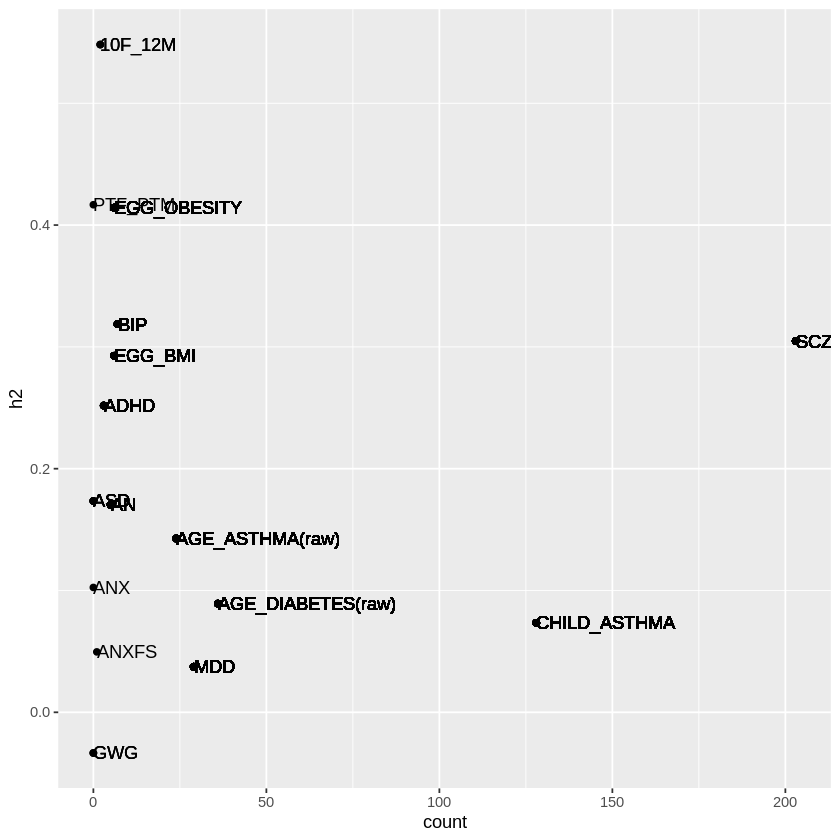

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'Prop._h2' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste

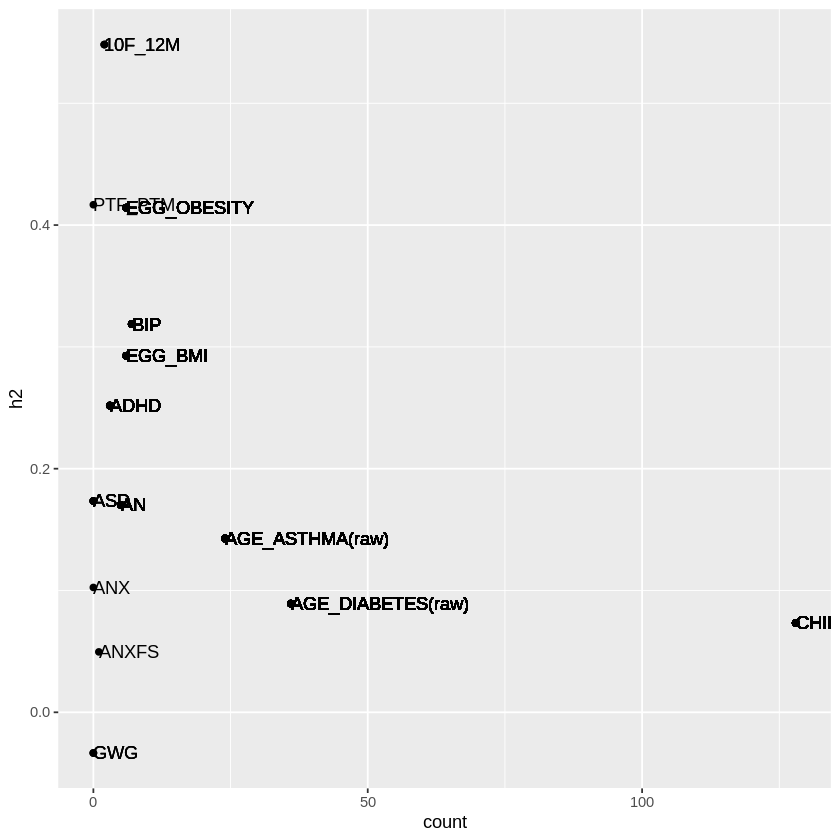

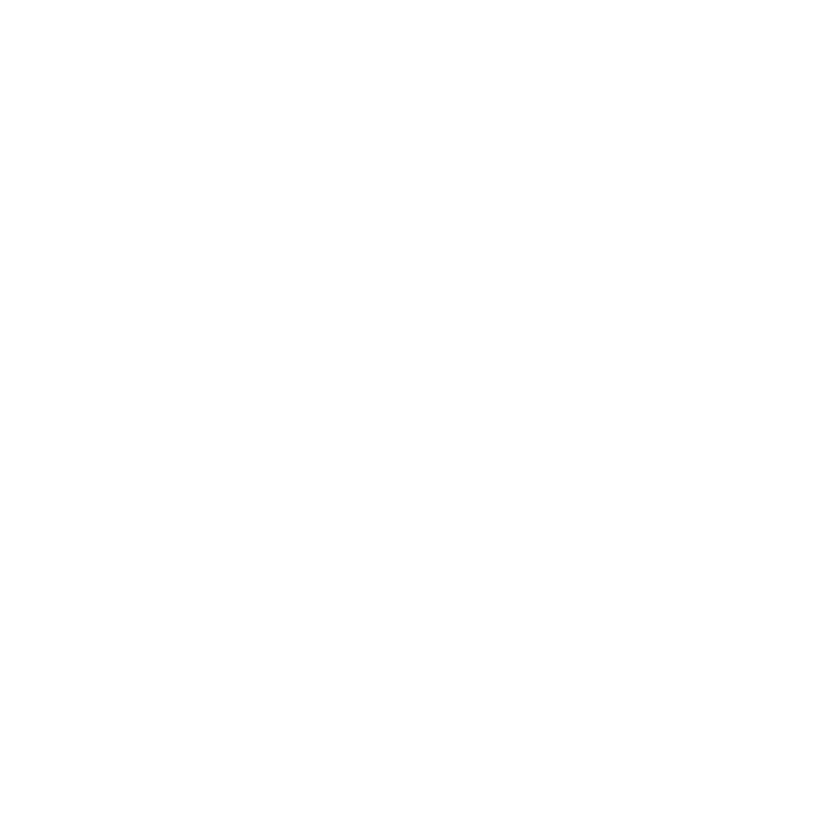

In [46]:
ggplot(all_data[,.(count=sum(PP.H4.abf >0.9),h2),by="GWAS"],aes(count,h2, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)
ggplot(all_data[,.(count=sum(PP.H4.abf >0.9),h2),by="GWAS"][GWAS != "SCZ" & GWAS != "MDD"],aes(count,h2, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)

ggplot(all_data[,.(count=sum(PP.H4.abf >0.9),h2),by="GWAS"],aes(count,Prop._h2, label=GWAS)) + 
    geom_point()+
    geom_text(hjust=0)

### More involved follow-up
Running colocalization of sex-stratified mQTL and sex-stratified GWAS